# Assignment 4

## Question 1 

In [1081]:
#Importing the libraries and create X and y datasets 

import numpy as np
import pandas as pd 

# We had to remove the first line of it as it had the file id starting with '#' therefore comment ="#" will ignore the line
# Header is not available for this dataset therefore None
df1 = pd.read_csv("week4_1.csv", header=None, comment = "#")
print(df1.head())

X1 = df1.iloc[:,0]
X2 = df1.iloc[:,1]
X = np.column_stack((X1,X2))
y = df1.iloc[:,2]

      0     1  2
0  0.87 -0.03  1
1  0.97 -0.87  1
2 -0.85  0.37  1
3 -0.10 -0.50  1
4  0.46  0.54 -1


Lets understand the data and do some exploration 

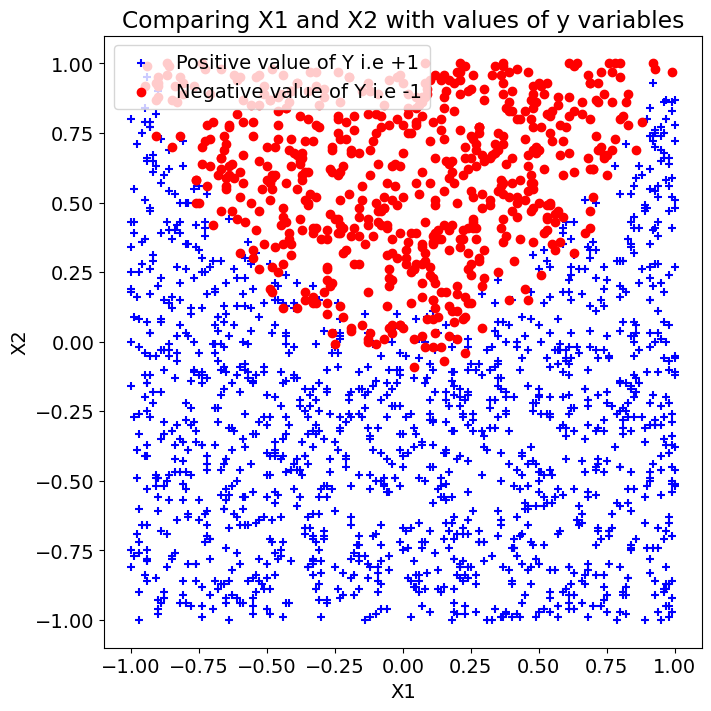

In [1082]:
# lets build of scatter plot first X1,x2 and y 
import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True

plt.figure(figsize = (7,7))
plt.rc('font',size =14 )

# We select y==1 condition in column 0 and column 1 and mark it as positive values for Y
plt.scatter(X[y==1,0],
            X[y==1,1], 
            marker="+", 
            color ="blue", 
            label="Positive value of Y i.e +1")

# We select y==-1 condition in column 0 and column 1 and mark it as negative values for Y
plt.scatter(X[y==-1,0],
            X[y==-1,1], 
            marker="o",
            color="red", 
            label="Negative value of Y i.e -1")

plt.title("Comparing X1 and X2 with values of y variables")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

/var/folders/9c/3z7htchs3r35xyhy05wqv5wc0000gn/T/ipykernel_1305/1369679237.py:6: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


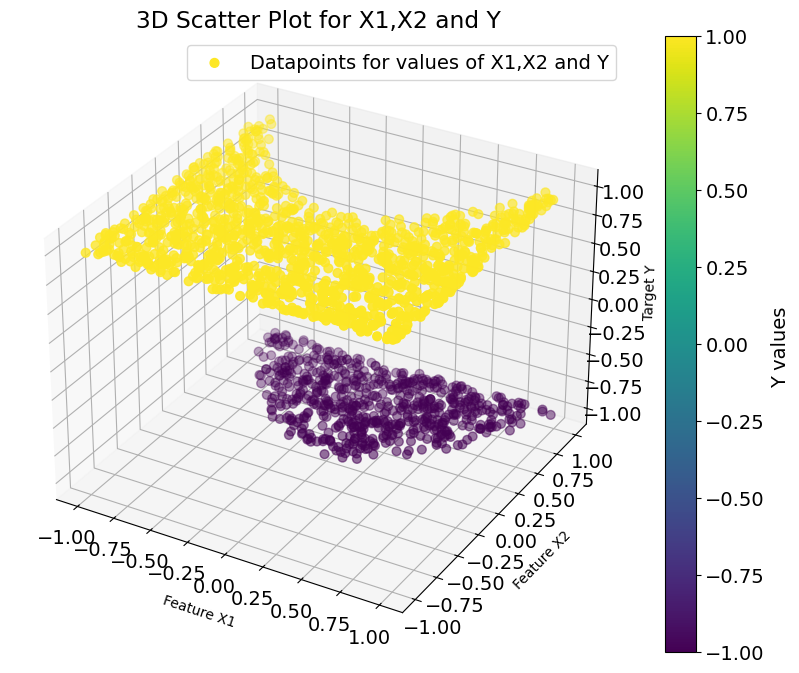

In [1083]:
#lets try it on a 3d plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #i need this for 3d plotting

fig = plt.figure(figsize = (10,8))
fig.tight_layout()


ax = fig.add_subplot(111,projection="3d" )


chart = ax.scatter(X[:,0],X[:,1],y,c=y,cmap="viridis", marker="o",s=40, label="Datapoints for values of X1,X2 and Y")
ax.set_title("3D Scatter Plot for X1,X2 and Y")
ax.set_xlabel("Feature X1",size=10,labelpad=8)
ax.set_ylabel("Feature X2",size=10,labelpad=8)
ax.set_zlabel("Target Y",labelpad=5,size=10) # labelpad just to allign how close or far i want the lable sot be for clear visibility

cbar = plt.colorbar(chart, ax=ax, shrink=1)
cbar.set_label("Y values ")
plt.legend()
plt.show()

# plt.zlabel("Y") there is no zlable due to which we have to try another approach

(i) Start with the first dataset.


(a) Using sklearn augment the two features in the dataset with polynomial features and train a Logistic Regression classifier with L2 penalty added to the cost function. Use cross-validation to select (i) the maximum order of polynomial to use and (ii) the weight C given to the penalty in the cost function. Remember you’ll also need to select the range of C values to consider and the range of maximum polynomial orders.

In [1084]:
# to pick the right metrics lets first analyse the dataset 
from collections import Counter 

print("Class counts : ", Counter(y)) #counts how many time each class is present in ou data

#returns the counts remove label
class_counts = np.array(list(Counter(y).values()), dtype=float)
#print(class_counts)

#imbalance ration
imbalance = class_counts.max()/class_counts.min()
print(f" Imbalance ratio is (max/min): {imbalance:.2f}")

# note if imbalance ratio is close to 1 then it is balanced and if it is larger then imbalanced 


Class counts :  Counter({1: 1306, -1: 624})
 Imbalance ratio is (max/min): 2.09


Our data is imbalanced then lets then pick the metrics suitable for imbalanced datasets which is f1 macro

Now i have to pikc the right values of C and degree using cross validation. The best approach is to select some values of degree and then loop over some values of C. print the error plots and anlyse which ones are best.

In [1085]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler,PolynomialFeatures


#hardcoded range 
degrees = [1,2,3,4,5,6,7,8,9,10]
#C_values = [0.001,0.01,0.1,1,10,100,1000,10000,100000]

# Let us specify what will be our values of C
C_values = np.logspace(-3,3,10) #this means that from logaithmically 10^-2 to 10^3 we have to find 10 numbers 
#why logarithmic now this will give us better coverage of small to learge values

# why making it complex - but this stratified 5 fold cv to keep each class porportion as we have imbalanced data
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

results = []

In [1086]:
for d in degrees:

    polynomial = PolynomialFeatures(degree=d, include_bias=False) # include_bias false is just not to add any constant
    X_multi = polynomial.fit_transform(X)


    #standardisation is important 
    scaler = StandardScaler()
    X_scal = scaler.fit_transform(X_multi)
    # why have i not used the code before because of data leakage issue here but as a part of this assignment we will ignore this

    for C in C_values:
        # i have to train model on logistic regression because it is imp to note that corss validation wont train by itself
        model = LogisticRegression(C=C, penalty="l2", solver = "lbfgs", max_iter=10000)

        # note that cross validation is just evaluation metric on diff folds
        #scores_acc = cross_val_score(model, X_multi,y, cv=5, scoring='accuracy')
        scores_f1 = cross_val_score(model, X_scal,y, cv=5, scoring='f1_macro')
        #scores_auc = cross_val_score(model, X_multi,y, cv=5, scoring='roc_auc')

        results.append([d,C,
                        #scores_acc.mean(), 
                        #scores_acc.std(),
                        scores_f1.mean(),
                        scores_f1.std()
                        #scores_auc.mean(),
                        #scores_auc.std()])
    
        ])
    

In [1087]:
"""# lets make a pipeline
from sklearn.pipeline import make_pipeline

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    
    for C in C_values:
        model = make_pipeline(
            poly,
            StandardScaler(),
            LogisticRegression(
                C=C,
                penalty="l2",
                solver = "lbfgs",
                max_iter=10000
            ))
        
        acc_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
        f1_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
        auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")

        results.append({
            "degree":d,
            "C":C,
            "mean_accuracy":acc_scores.mean(),
            "std_accuracy":acc_scores.std(),
            "mean_f1":f1_scores.mean(),
            "std_f1": f1_scores.std(),
            "mean_auc": auc_scores.mean(),
            "std_auc": auc_scores.std(),
        })"""



'# lets make a pipeline\nfrom sklearn.pipeline import make_pipeline\n\nfor d in degrees:\n    poly = PolynomialFeatures(degree=d, include_bias=False)\n\n    for C in C_values:\n        model = make_pipeline(\n            poly,\n            StandardScaler(),\n            LogisticRegression(\n                C=C,\n                penalty="l2",\n                solver = "lbfgs",\n                max_iter=10000\n            ))\n\n        acc_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")\n        f1_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")\n        auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")\n\n        results.append({\n            "degree":d,\n            "C":C,\n            "mean_accuracy":acc_scores.mean(),\n            "std_accuracy":acc_scores.std(),\n            "mean_f1":f1_scores.mean(),\n            "std_f1": f1_scores.std(),\n            "mean_auc": auc_scores.mean(),\n            "std_auc": auc_scores.std(),\n     

In [1088]:

res_df = pd.DataFrame(results, columns=['degree','C','mean_f1','std_f1'])
#print(res_df.head())
#print(res_df.shape)
print(res_df)
                                       

    degree            C   mean_f1    std_f1
0        1     0.001000  0.403584  0.000368
1        1     0.004642  0.800137  0.017903
2        1     0.021544  0.838889  0.017277
3        1     0.100000  0.847832  0.017281
4        1     0.464159  0.850056  0.016835
..     ...          ...       ...       ...
95      10     2.154435  0.949545  0.010161
96      10    10.000000  0.949598  0.010087
97      10    46.415888  0.951532  0.009398
98      10   215.443469  0.950362  0.010162
99      10  1000.000000  0.951532  0.009398

[100 rows x 4 columns]


In [1089]:
#mathemtiaclly analysing the f1 score lets pick the best value and then we can check this wth our plots later
# Lets analyse the df and try to pcik the row with highest mean_f1

high_mean = res_df.loc[res_df['mean_f1'].idxmax()]
best_degree = int(high_mean['degree'])
best_c = float(high_mean["C"])

print("Best degree by F1", best_degree)
print("Best c value :", best_c)
print(high_mean)

Best degree by F1 2
Best c value : 10.0
degree      2.000000
C          10.000000
mean_f1     0.953814
std_f1      0.008264
Name: 16, dtype: float64


Its not feasible for us to print error bar for every value of degree and c values clearly as we can see the shape of the res_df. So best option is to probably group these into degree and then print the graph so that way it will be easier for us to observe the graph.

/var/folders/9c/3z7htchs3r35xyhy05wqv5wc0000gn/T/ipykernel_1305/955190952.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


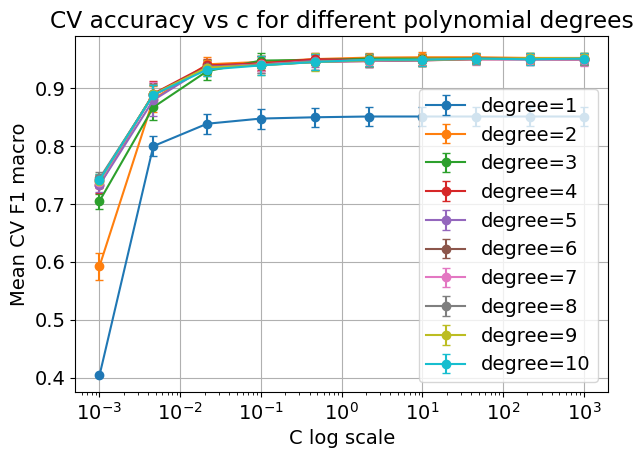

In [1090]:
plt.figure()

for d in sorted(res_df['degree'].unique()):
    sub = res_df[res_df['degree']==d].sort_values('C')

    plt.errorbar(
        sub['C'],  #here we are basiaclly converting this into logscale for plotting so our values are same butjust a visual trasnformation for readabiity 
        sub['mean_f1'],
        yerr=sub['std_f1'],
        capsize=3,
        marker='o',
        label=f"degree={d}"
    )

plt.xscale("log")
plt.xlabel("C log scale")
plt.ylabel("Mean CV F1 macro")
plt.title("CV accuracy vs c for different polynomial degrees")


plt.grid(True)
plt.legend()
#plt.ylim(sub['mean_accuracy'].min()-0.02, sub['mean_accuracy'].max()+0.002)

plt.tight_layout()
plt.show()

Now there is a lot of overlapping here so lets map 1 plot per degree for variable values of C so that way it will be clear and you will be ablr to identify the issue

/var/folders/9c/3z7htchs3r35xyhy05wqv5wc0000gn/T/ipykernel_1305/3432161419.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


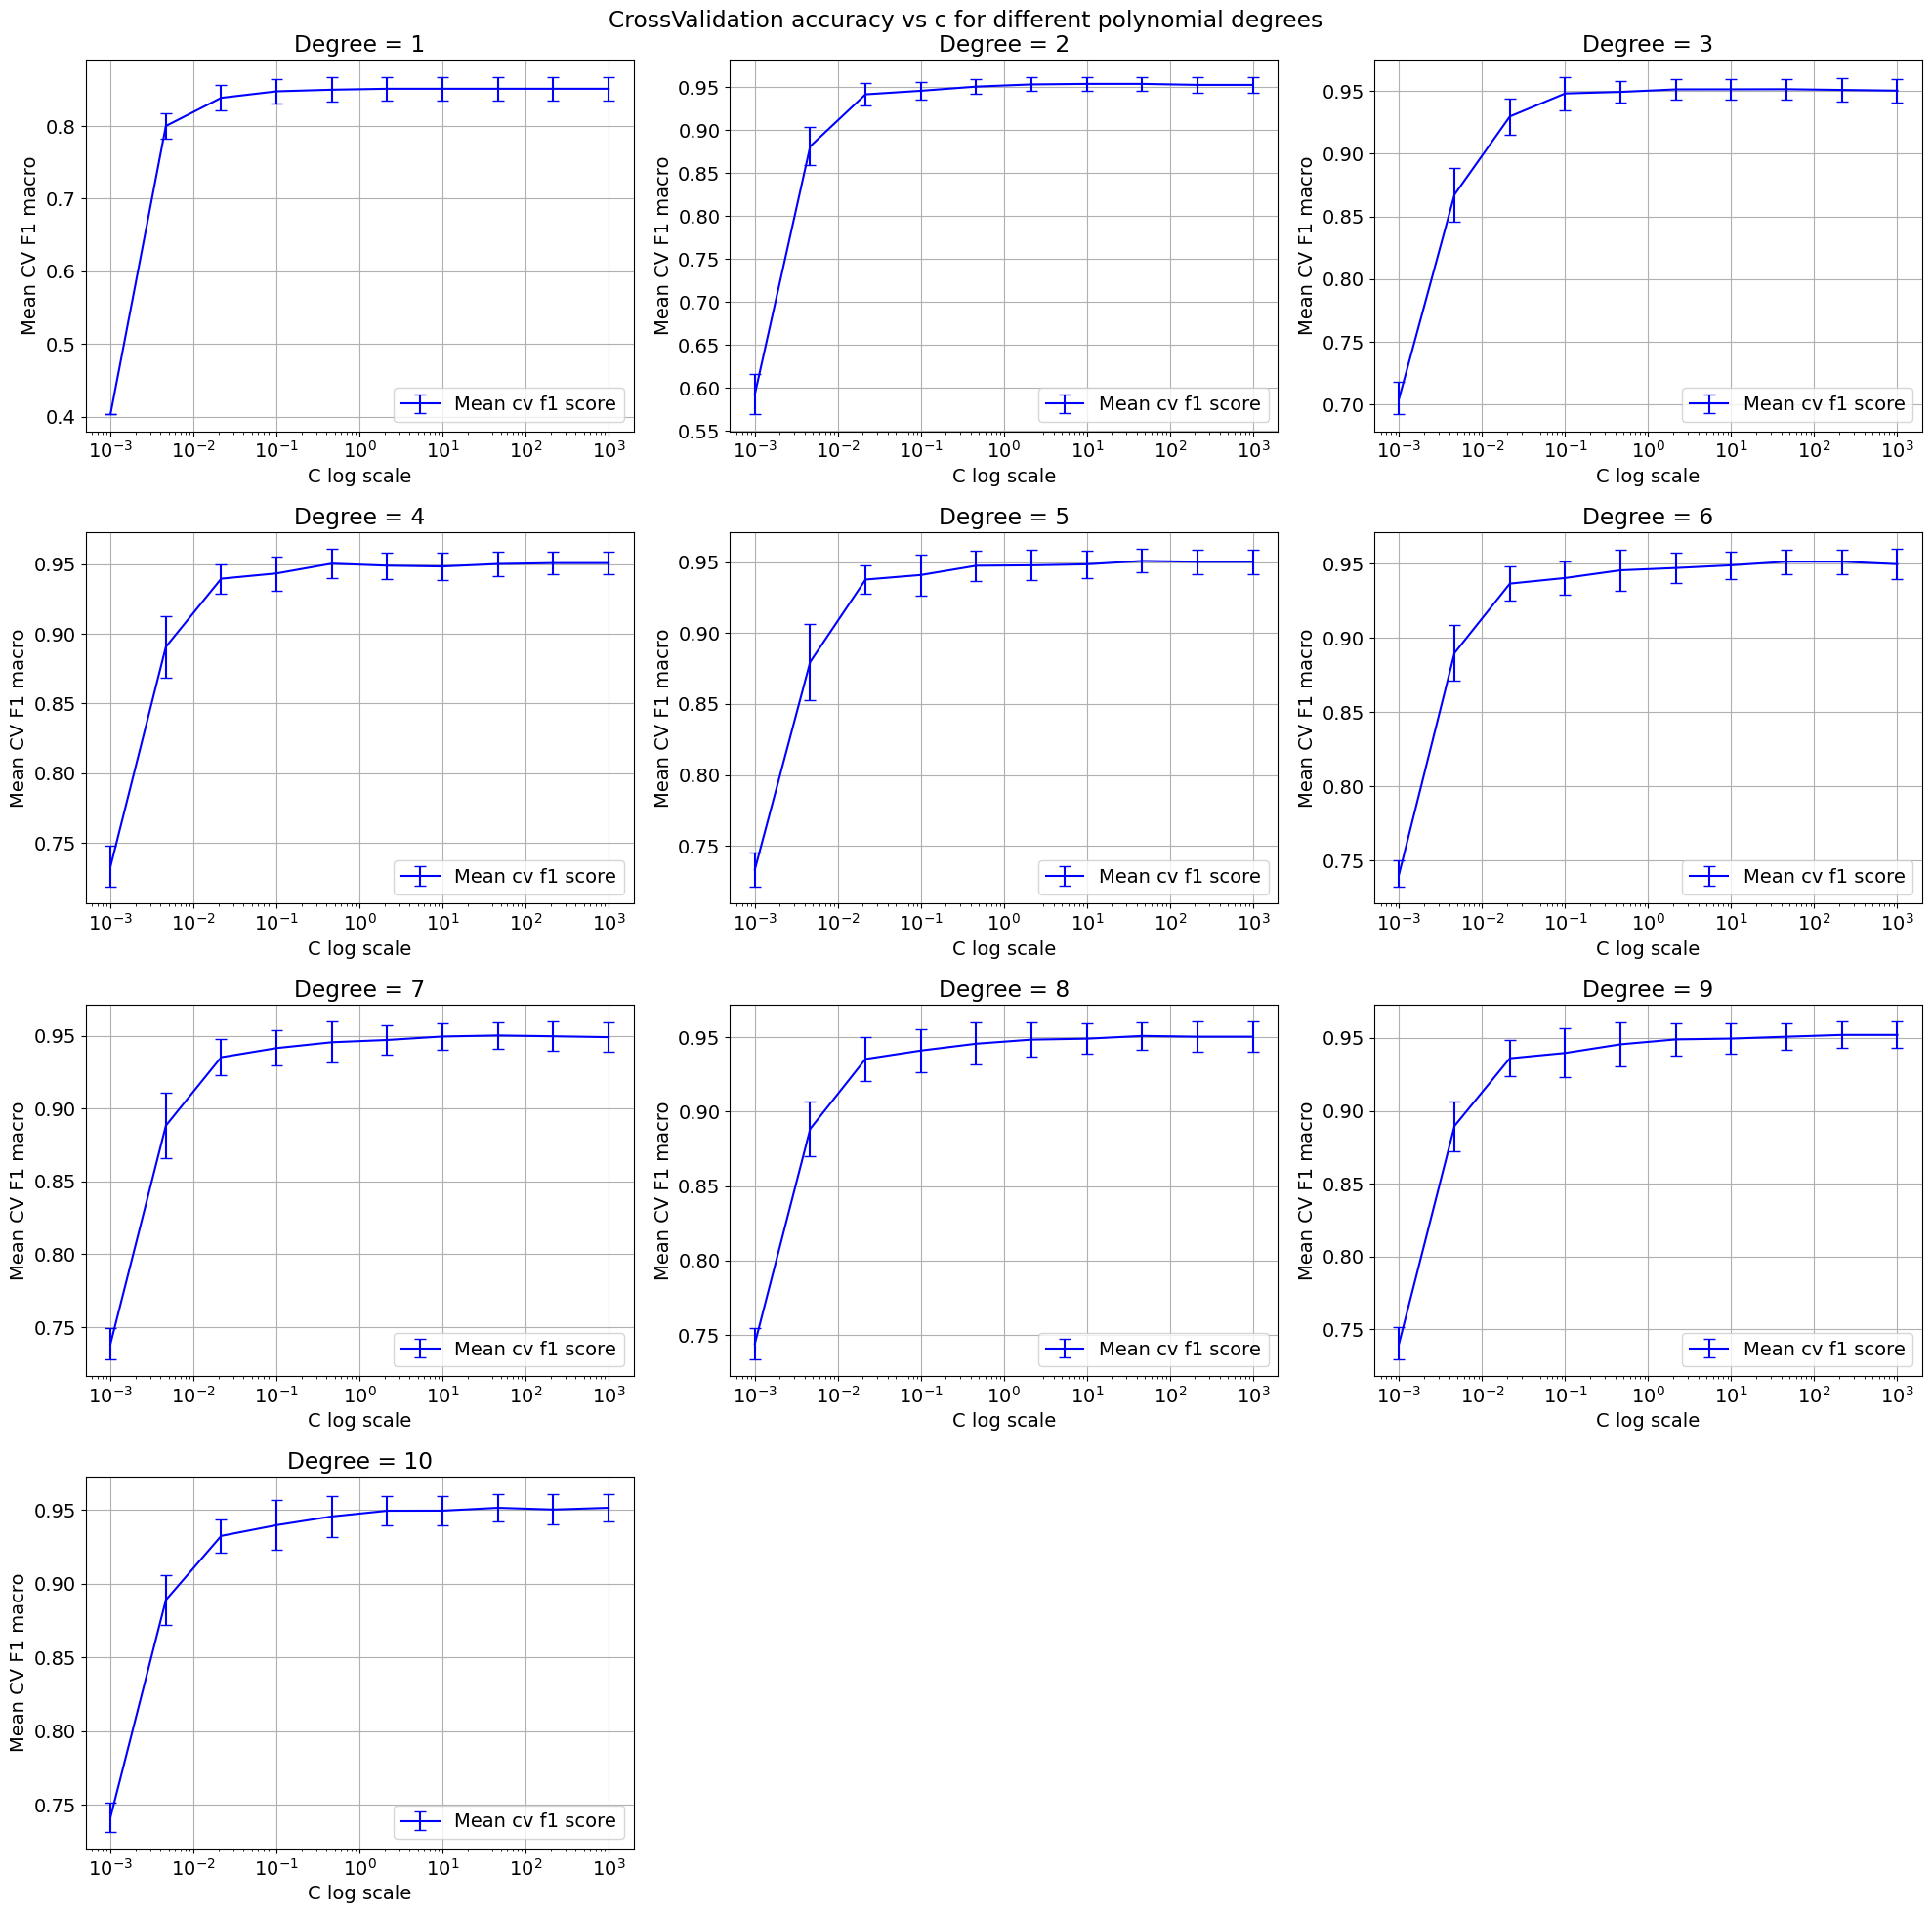

In [1091]:
# lets have a grid type structure to be able to compare everything on a single plot side by side

cols = 3
rows = 4 #why because we have 10 plots divided by 3 cols so we need 4 rows 

plt.figure(figsize=(20,20))

for i,d in enumerate(degrees, 1):  #iterate with i=1, d=1 and i=2, d=2 and so on
    sub = res_df[res_df['degree']==d].sort_values('C') #only choose degree as d this is for condition within loop 
    plt.subplot(rows,cols,i)

    plt.errorbar(
        sub['C'],
        sub['mean_f1'], #mean is on Y axis 
        yerr = sub['std_f1'],   # here we have std deviation to show how values have deviated from the catual value in the graph
        capsize=4,
        color='blue',
        label="Mean cv f1 score"

    )
    plt.xscale("log")
    plt.xlabel("C log scale")
    plt.ylabel("Mean CV F1 macro")
    plt.legend()

    plt.title(f"Degree = {d}")
    plt.grid(True)

plt.suptitle("CrossValidation accuracy vs c for different polynomial degrees")
plt.tight_layout()
plt.show()

    



what we should look for :
1. i have to check the short or long error bar: we prefer short error bar >less deviation from value
2. mean f1 should be highest 
3. smallest value of C
all of this is clearly in degree=2 and c is not clear so lets maginify that

/var/folders/9c/3z7htchs3r35xyhy05wqv5wc0000gn/T/ipykernel_1305/3511674387.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Degree = 2')

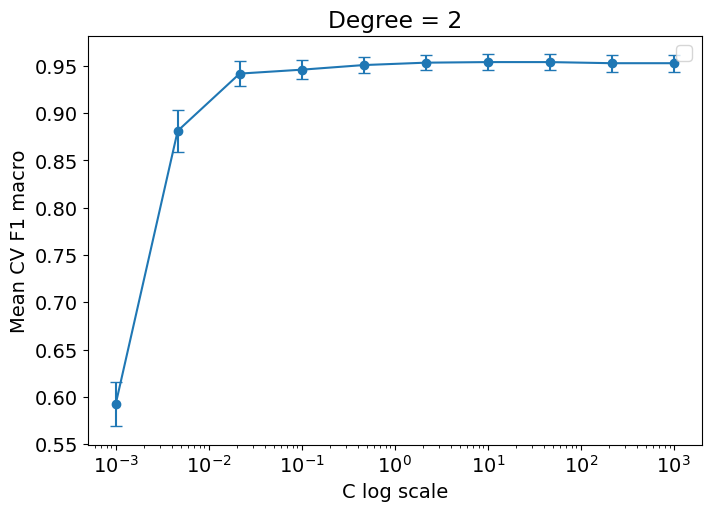

In [1092]:
C_values = np.logspace(-3,1,10) 

sub = res_df[res_df['degree']==2].sort_values('C') #only choose degree as d this is for condition within loop 

plt.figure(figsize=(7,5))

plt.errorbar(
    sub['C'],
    sub['mean_f1'],
    yerr=sub['std_f1'],
    capsize = 4,
    marker='o',
)

plt.xscale("log")
plt.xlabel("C log scale")
plt.ylabel("Mean CV F1 macro")
plt.legend()
plt.title(f"Degree = 2")


Text(0.5, 1.0, 'Degree = 2')

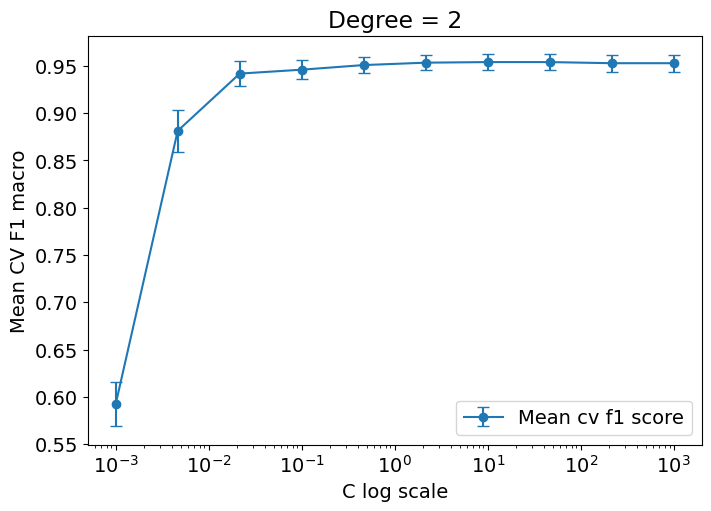

In [1093]:
C_values = np.logspace(-3,1,10) 

sub = res_df[res_df['degree']==2].sort_values('C') #only choose degree as d this is for condition within loop 

plt.figure(figsize=(7,5))

plt.errorbar(
    sub['C'],
    sub['mean_f1'],
    yerr=sub['std_f1'],
    capsize = 4,
    marker='o',
    label="Mean cv f1 score"
)

plt.xscale("log")
plt.xlabel("C log scale")
plt.ylabel("Mean CV F1 macro")
plt.legend()
plt.title(f"Degree = 2")

Now important thing to note here is that after C=10 you dont see any rise in the graph and it becomes stable so this is the perfect C value for us

Therefore this matches our statistically proven assumption

In [ ]:
# FInal model traning with chose hyperparameters above 

polynomial = PolynomialFeatures(degree=d, include_bias=False) # include_bias false is just not to add any constant
X_multi = polynomial.fit_transform(X)

#standardisation is important 
scaler = StandardScaler()
X_scal = scaler.fit_transform(X_multi)

"""best_degree = int(high_mean['degree'])
best_c = float(high_mean["C"])"""

model_logistic = LogisticRegression(C=best_c, penalty='l2',solver='lbfgs', max_iter=10000)
model_logistic.fit(X_scal, y)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,10.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


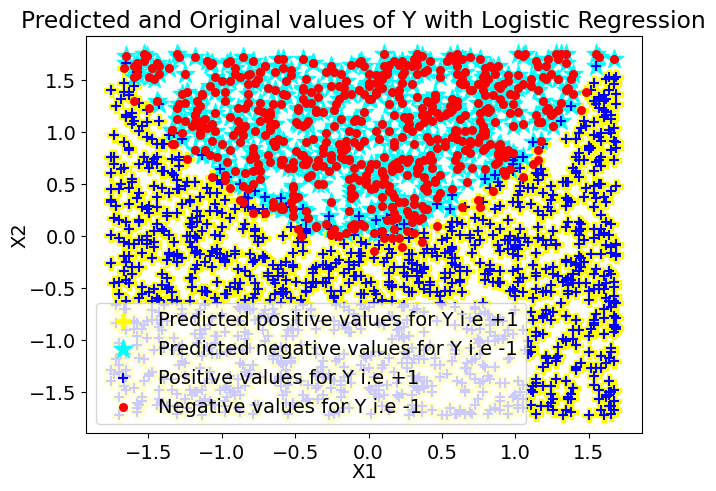

In [1095]:
ypred = model_logistic.predict(X_scal)
log_scores = model_logistic.predict_proba(X_scal)[:,1]


plt.scatter(X_scal[ypred==1,0],
            X_scal[ypred==1,1], 
            marker="P", 
            color ="yellow",
            label="Predicted positive values for Y i.e +1",
            s=100)

plt.scatter(X_scal[ypred==-1,0],
            X_scal[ypred==-1,1], 
            marker="*",
            color="cyan", 
            label="Predicted negative values for Y i.e -1",
            s=200)

plt.scatter(X_scal[y==1,0],
            X_scal[y==1,1], 
            marker="+", 
            color ="blue", 
            label="Positive values for Y i.e +1",
            s=50)

plt.scatter(X_scal[y==-1,0],
            X_scal[y==-1,1], 
            marker="o",
            color="red", 
            label="Negative values for Y i.e -1",
            s=30)

plt.title("Predicted and Original values of Y with Logistic Regression")
plt.xlabel("X1",labelpad=-0.12)
plt.ylabel("X2",labelpad=-0.12)
plt.legend()


In [1096]:
"""xmin, xmax = X[:,0].min() - 0.5, X[:,0].max() + 0.5
ymin, ymax = X[:,1].min() - 0.5, X[:,1].max() + 0.5

xx,yy = np.meshgrid(np.linspace(xmin,xmax,200),
                    np.linspace(ymin,ymax,200))

gridp = np.c_[xx.ravel(),yy.ravel()]
grid_multi = polynomial.transform(gridp)
grid_scal = scaler.transform(grid_multi)

Z = model_logistic.predict(grid_scal).reshape(xx.shape)


plt.figure(figsize=(6,5))
plt.contourf(xx,yy,Z, alpha=0.3, levels=2)
plt.scatter(X[y==1,0],X[y==1,1], color='blue', marker="+", label="y as +1")
plt.scatter(X[y==-1,0],X[y==-1,1], color='red', marker="+", label="y as +1")
plt.xlabel("Feature X1")
plt.ylabel("Feature X2")
plt.title(f"Decision Boundary for Degree {best_degree} and C={best_c}")
plt.legend()
plt.tight_layout()
plt.show()
          """



'xmin, xmax = X[:,0].min() - 0.5, X[:,0].max() + 0.5\nymin, ymax = X[:,1].min() - 0.5, X[:,1].max() + 0.5\n\nxx,yy = np.meshgrid(np.linspace(xmin,xmax,200),\n                    np.linspace(ymin,ymax,200))\n\ngridp = np.c_[xx.ravel(),yy.ravel()]\ngrid_multi = polynomial.transform(gridp)\ngrid_scal = scaler.transform(grid_multi)\n\nZ = model_logistic.predict(grid_scal).reshape(xx.shape)\n\n\nplt.figure(figsize=(6,5))\nplt.contourf(xx,yy,Z, alpha=0.3, levels=2)\nplt.scatter(X[y==1,0],X[y==1,1], color=\'blue\', marker="+", label="y as +1")\nplt.scatter(X[y==-1,0],X[y==-1,1], color=\'red\', marker="+", label="y as +1")\nplt.xlabel("Feature X1")\nplt.ylabel("Feature X2")\nplt.title(f"Decision Boundary for Degree {best_degree} and C={best_c}")\nplt.legend()\nplt.tight_layout()\nplt.show()\n          '

(b) Now train a kNN classifier on the data. Use cross-validation to select k, again presenting data and explanations/analysis to justify your choice. There is no need to augment the features with polynomial features for a kNN classifier, kNN can already capture nonlinear decision boundaries.
Again, it is essential that you present data and give clear explanations/analysis to justify your choices.


In [1097]:
#from previous section
"""#hardcoded range 
degrees = [1,2,3,4,5,6,7,8,9,10]
#C_values = [0.001,0.01,0.1,1,10,100,1000,10000,100000]

# Let us specify what will be our values of C
C_values = np.logspace(-3,3,10) #this means that from logaithmically 10^-2 to 10^3 we have to find 10 numbers 
#why logarithmic now this will give us better coverage of small to learge values

# why making it complex - but this stratified 5 fold cv to keep each class porportion as we have imbalanced data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#standardisation is important 
scaler = StandardScaler()
X_scal = scaler.fit_transform(X_multi)
"""
from sklearn.neighbors import KNeighborsClassifier

# now everything from previous section ive pasted here and we start the same orcess but for Knn
# now this time the complaexity is less because we just have to parse thorugh diff values of degree 
#there is no C 

k_values=range(1,20)

res_knn=[]
for k in k_values:
        

        model_knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')

        # note that cross validation is just evaluation metric on diff folds
        #scores_acc = cross_val_score(model, X_multi,y, cv=5, scoring='accuracy')
        f1_scores = cross_val_score(model_knn, X, y, cv=5, scoring='f1_macro')
        #scores_auc = cross_val_score(model, X_multi,y, cv=5, scoring='roc_auc')

        res_knn.append([k,
                        #scores_acc.mean(), 
                        #scores_acc.std(),
                        f1_scores.mean(),
                        f1_scores.std()
                        #scores_auc.mean(),
                        #scores_auc.std()])
    
        ])

res_knn_df = pd.DataFrame(res_knn, columns=['k','mean_f1','std_f1'])
print(res_knn_df)
    




     k   mean_f1    std_f1
0    1  0.934829  0.013042
1    2  0.936923  0.017226
2    3  0.938864  0.013059
3    4  0.941457  0.010060
4    5  0.941901  0.008750
5    6  0.941498  0.009378
6    7  0.945114  0.009126
7    8  0.945494  0.010961
8    9  0.945042  0.009383
9   10  0.947746  0.008789
10  11  0.945135  0.010067
11  12  0.944240  0.009649
12  13  0.944539  0.012123
13  14  0.944258  0.011216
14  15  0.942213  0.012654
15  16  0.943088  0.012578
16  17  0.944616  0.015390
17  18  0.946615  0.011841
18  19  0.947506  0.013749


In [1098]:
# now as done previously im going to find the best C mathematically 
best_entry_knn = res_knn_df.loc[res_knn_df['mean_f1'].idxmax()]
best_k = int(best_entry_knn['k'])
print("Best value of k by f1 is : ", best_k)
print(best_entry_knn)

Best value of k by f1 is :  10
k          10.000000
mean_f1     0.947746
std_f1      0.008789
Name: 9, dtype: float64


/var/folders/9c/3z7htchs3r35xyhy05wqv5wc0000gn/T/ipykernel_1305/2699355750.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


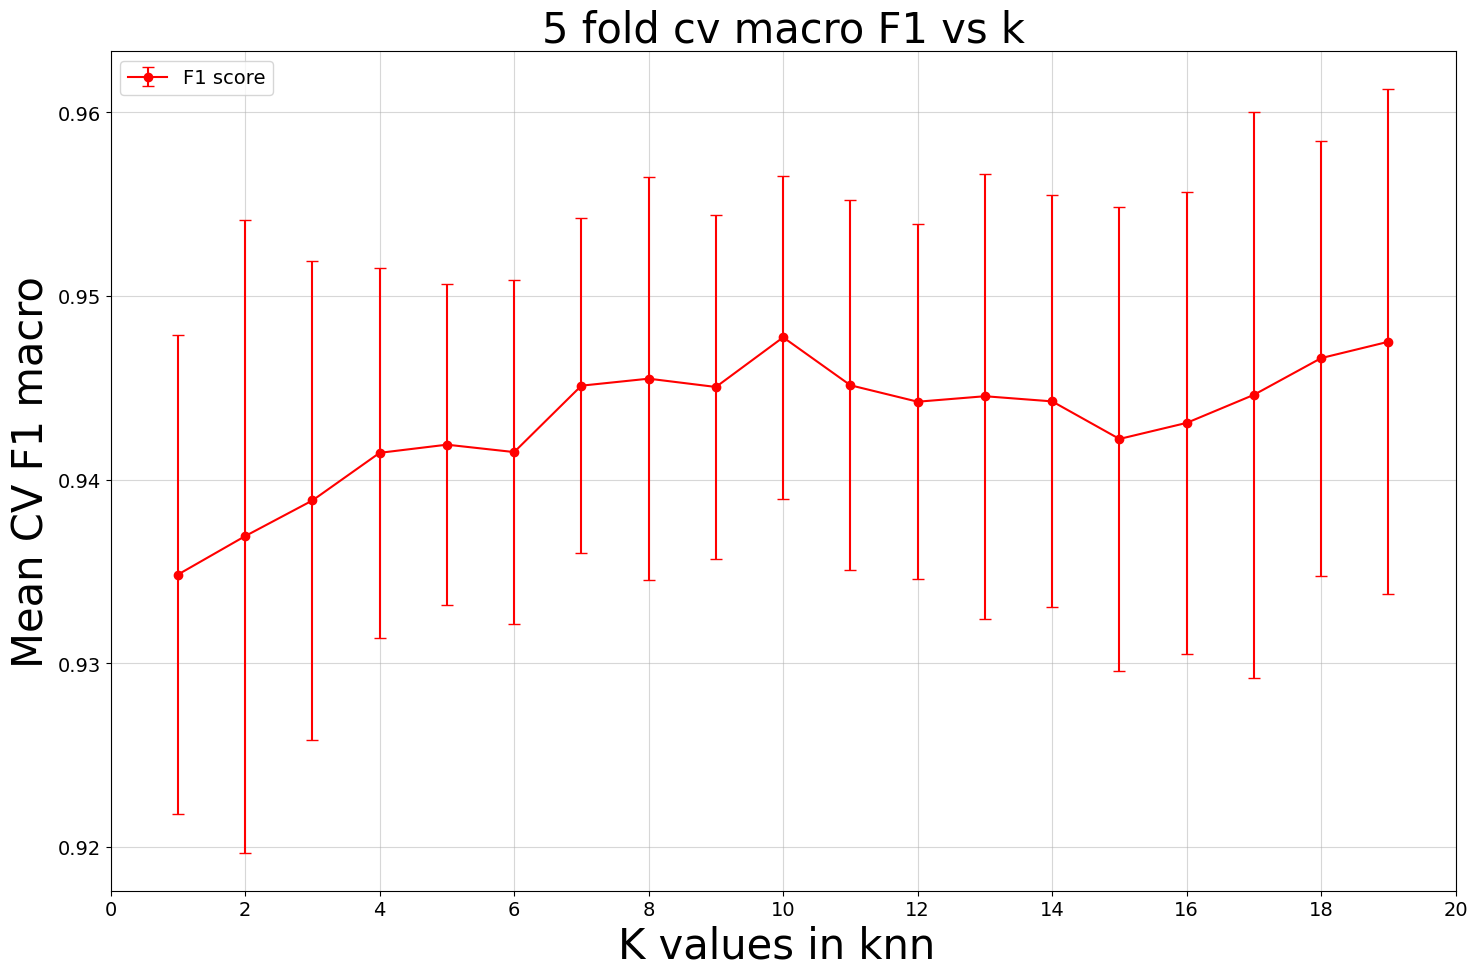

In [1099]:
# here there is no need for multiple plots because tchnically we will have only 1 plot 
# x axis will be k values
# y will be mean of f1 scores and the std deiation with the error bar 

plt.figure(figsize=(15,10))
plt.errorbar(
    res_knn_df['k'],
    res_knn_df['mean_f1'],
    yerr = res_knn_df['std_f1'],
    capsize=4,
    marker='o',
    color='red',
    label='F1 score',
)
plt.xlabel("K values in knn ",size=30)
plt.ylabel("Mean CV F1 macro",size=30)
plt.xticks(range(0,21,2))
plt.title("5 fold cv macro F1 vs k",size=30)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.legend()

plt.show()

    



1. small k = more flexible and might react to any noise in the data
2. big k = smoother averages more neighbour but less flwible 
3. short bar =. stable model and similar performnace in every fold
4. long bar = unstable model

from k=8-10 the model plateaus  and after k>15 it becomes too smooth 
we pick k=18 no ? because yes f1 is highest but the variance so unstable 
so we want accurate (high f1), stable(small error bar), simple(smallest k)

therefore we pick k=9 the smallest error bar and f1 is highest 

In [1100]:
# FInal model traning with chose hyperparameters above 
#standardisation is important 

"""best_degree = int(high_mean['degree'])
best_c = float(high_mean["C"])"""

model_knn = KNeighborsClassifier(n_neighbors=9, weights='uniform')
model_knn.fit(X, y)

ypred_knn = model_knn.predict(X)
knn_scores = model_knn.predict_proba(X)[:,1]




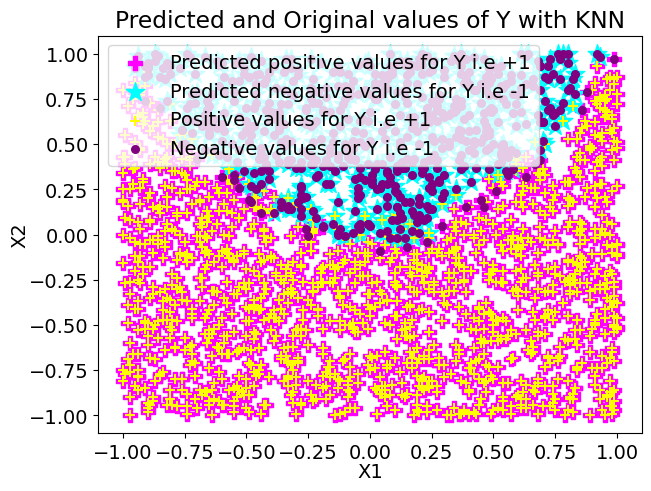

In [1101]:

plt.scatter(X[ypred_knn==1,0],
            X[ypred_knn==1,1], 
            marker="P", 
            color ="magenta",
            label="Predicted positive values for Y i.e +1",
            s=100)

plt.scatter(X[ypred_knn==-1,0],
            X[ypred_knn==-1,1], 
            marker="*",
            color="cyan", 
            label="Predicted negative values for Y i.e -1",
            s=200)

plt.scatter(X[y==1,0],
            X[y==1,1], 
            marker="+", 
            color ="yellow", 
            label="Positive values for Y i.e +1",
            s=50)

plt.scatter(X[y==-1,0],
            X[y==-1,1], 
            marker="o",
            color="purple", 
            label="Negative values for Y i.e -1",
            s=30)

plt.title("Predicted and Original values of Y with KNN")
plt.xlabel("X1",labelpad=-0.12)
plt.ylabel("X2",labelpad=-0.12)
plt.legend()


(c) Calculate the confusion matrices for your trained Logistic Regression and
kNN classifier. Also calculate the confusion matrix for one or more baseline classifiers of your choice e.g. one that always predicts the most frequent class in the training data and/or one that makes random predictions.


In [1102]:
# we have evlauted on full training data because we have not done splitting in previous steps
from sklearn.dummy import DummyClassifier

dummy_majority_pred = DummyClassifier(strategy="most_frequent")
dummy_majority_pred.fit(X,y)
y_pred_majority = dummy_majority_pred.predict(X)

dummy_random_pick = DummyClassifier(strategy="uniform",random_state=0)
dummy_random_pick.fit(X,y)
y_pred_random = dummy_random_pick.predict(X)

In [1103]:
#Confusion matrix of all data 
label=[-1,1]

from sklearn.metrics import confusion_matrix, classification_report

print("Confusion matrix for logistic regression")
print(confusion_matrix(y, ypred, labels=label))


print("Confusion matrix for logistic regression")
print(classification_report(y, ypred, labels=label))



Confusion matrix for logistic regression
[[ 586   38]
 [  38 1268]]
Confusion matrix for logistic regression
              precision    recall  f1-score   support

          -1       0.94      0.94      0.94       624
           1       0.97      0.97      0.97      1306

    accuracy                           0.96      1930
   macro avg       0.96      0.96      0.96      1930
weighted avg       0.96      0.96      0.96      1930




Actual -1 and predicted -1 = 586<br>
Actual -1 and predicted +1 = 38<br>
Actual +1 and predicted -1 = 38<br>
Actual +1 and predicted +1 = 1286


In [1104]:
print("Confusion matrix for KNN")
print(confusion_matrix(y, ypred_knn, labels=label))

print("Classification report for KNN")
print(classification_report(y, ypred_knn, labels=label))


Confusion matrix for KNN
[[ 592   32]
 [  36 1270]]
Classification report for KNN
              precision    recall  f1-score   support

          -1       0.94      0.95      0.95       624
           1       0.98      0.97      0.97      1306

    accuracy                           0.96      1930
   macro avg       0.96      0.96      0.96      1930
weighted avg       0.96      0.96      0.96      1930



Actual -1 and predicted -1 = 598<br>
Actual -1 and predicted +1 = 26<br>
Actual +1 and predicted -1 = 45<br>
Actual +1 and predicted +1 = 1261

In [1105]:
print("Confusion matrix for Baseline predictor majority  ")
print(confusion_matrix(y, y_pred_majority, labels=label))

print("Classification report for Baseline predictor majority ")
print(classification_report(y, y_pred_majority, labels=label))

Confusion matrix for Baseline predictor majority  
[[   0  624]
 [   0 1306]]
Classification report for Baseline predictor majority 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       624
           1       0.68      1.00      0.81      1306

    accuracy                           0.68      1930
   macro avg       0.34      0.50      0.40      1930
weighted avg       0.46      0.68      0.55      1930



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

Actual -1 and predicted -1 = 0<br>
Actual -1 and predicted +1 = 624<br>
Actual +1 and predicted -1 = 0<br>
Actual +1 and predicted +1 = 1306

In [1106]:
print("Confusion matrix for Baseline predictor random  ")
print(confusion_matrix(y, y_pred_random, labels=label))

print("Classification report for Baseline predictor random ")
print(classification_report(y, y_pred_random, labels=label))

Confusion matrix for Baseline predictor random  
[[314 310]
 [637 669]]
Classification report for Baseline predictor random 
              precision    recall  f1-score   support

          -1       0.33      0.50      0.40       624
           1       0.68      0.51      0.59      1306

    accuracy                           0.51      1930
   macro avg       0.51      0.51      0.49      1930
weighted avg       0.57      0.51      0.53      1930



Actual -1 and predicted -1 = 314<br>
Actual -1 and predicted +1 = 310<br>
Actual +1 and predicted -1 = 637<br>
Actual +1 and predicted +1 = 669

(d) Plot the ROC curves for your trained Logistic Regression and kNN classifiers. Also plot the point(s) on the ROC plot corresponding to the baseline classifiers. Be sure to include enough points in the ROC curves to allow the detailed shape to be seen.

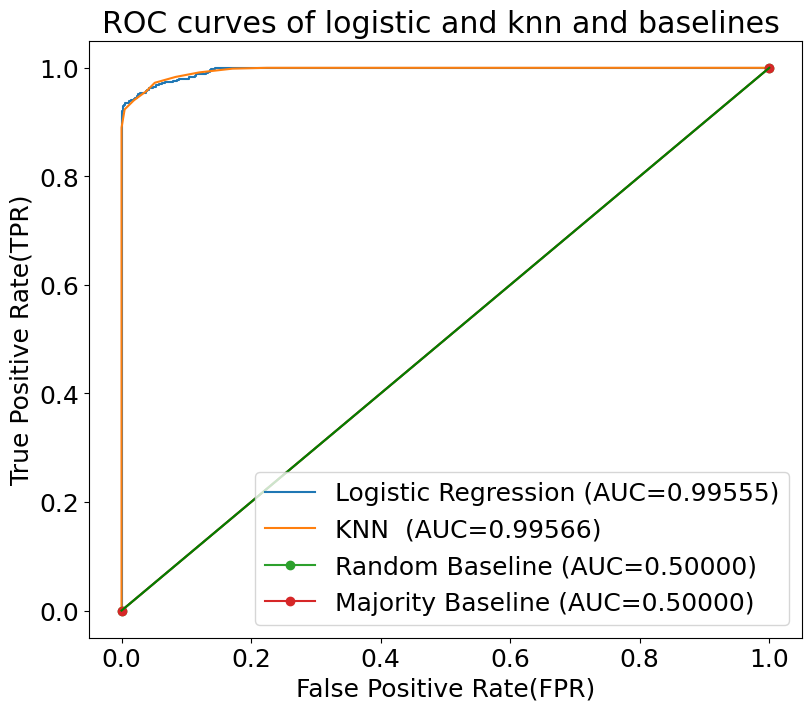

In [1107]:
# we need 

from sklearn.metrics import roc_auc_score, roc_curve

#log_scores = model_logistic.predict_proba(X_scal)[:,1]
#knn_scores = model_knn.predict_proba(X1_scal)[:,1]

random_scores = dummy_random_pick.predict_proba(X)[:,1]
majority_scores = dummy_majority_pred.predict_proba(X)[:,1]

fpr_log, tpr_log, _=roc_curve(y,log_scores, pos_label=1)
fpr_knn, tpr_knn, _=roc_curve(y,knn_scores, pos_label=1)
fpr_rd, tpr_rd, _=roc_curve(y,random_scores, pos_label=1)
fpr_maj, tpr_maj, _=roc_curve(y,majority_scores, pos_label=1)


auc_log=roc_auc_score(y,log_scores)
auc_knn=roc_auc_score(y,knn_scores)
auc_rd=roc_auc_score(y,random_scores)
auc_maj=roc_auc_score(y,majority_scores)


plt.rc('font', size=18)
plt.rcParams['figure.constrained_layout.use']=True
plt.figure(figsize=(8,7))

plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC={auc_log:.5f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN  (AUC={auc_knn:.5f})")

plt.plot(fpr_rd, tpr_rd, label=f"Random Baseline (AUC={auc_rd:.5f})",marker="o")
plt.plot(fpr_maj, tpr_maj, label=f"Majority Baseline (AUC={auc_maj:.5f})",marker="o")



plt.plot([0,1],[0,1], color="green")

plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC curves of logistic and knn and baselines ")
plt.legend()
plt.show()








(e) Using the data from (c) and (d) evaluate and compare the performance of the Logistic Regression, kNN and baseline classifiers. Is one classifier significantly better or worse than the other? How do their ROC curves compare with that of a random classifier. Which classifier, if any, would you recommend be used?
Explain the reasoning behind you recommendation.


This is answered in report itself 

## Question 2 

In [1108]:
#Importing the libraries and create X and y datasets 

import numpy as np
import pandas as pd 

# We had to remove the first line of it as it had the file id starting with '#' therefore comment ="#" will ignore the line
# Header is not available for this dataset therefore None
df2 = pd.read_csv("week4_2.csv", header=None, comment = "#")
print(df2.head())

X1_2 = df2.iloc[:,0]
X2_2 = df2.iloc[:,1]
X2 = np.column_stack((X1_2,X2_2))
y2 = df2.iloc[:,2]

      0     1  2
0 -0.60  0.26  1
1  0.45 -0.50  1
2 -0.09 -0.32 -1
3  0.10 -0.34 -1
4 -0.49  0.84  1


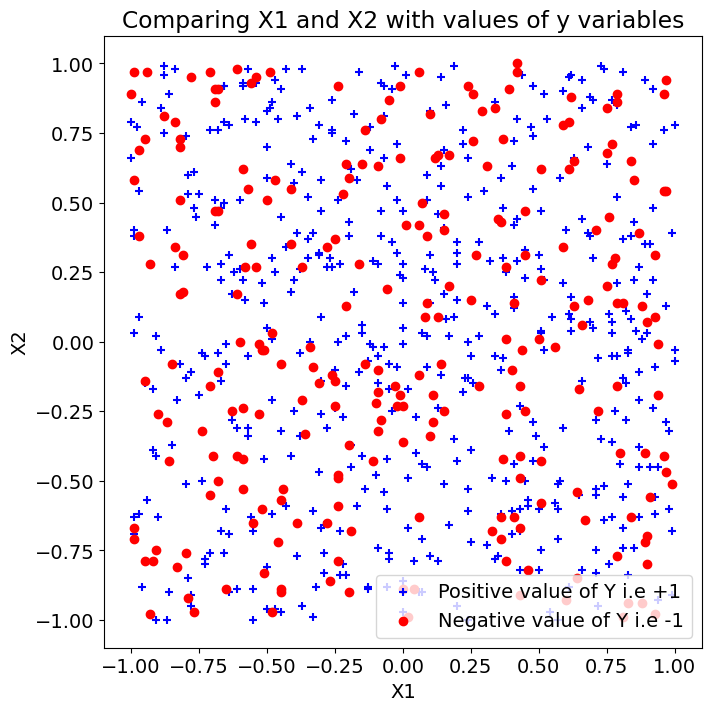

In [1109]:
# lets build of scatter plot first X1,x2 and y 
import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True

plt.figure(figsize = (7,7))
plt.rc('font',size =14 )

# We select y==1 condition in column 0 and column 1 and mark it as positive values for Y
plt.scatter(X2[y2==1,0],
            X2[y2==1,1], 
            marker="+", 
            color ="blue", 
            label="Positive value of Y i.e +1")

# We select y==-1 condition in column 0 and column 1 and mark it as negative values for Y
plt.scatter(X2[y2==-1,0],
            X2[y2==-1,1], 
            marker="o",
            color="red", 
            label="Negative value of Y i.e -1")

plt.title("Comparing X1 and X2 with values of y variables")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

/var/folders/9c/3z7htchs3r35xyhy05wqv5wc0000gn/T/ipykernel_1305/2330338747.py:6: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


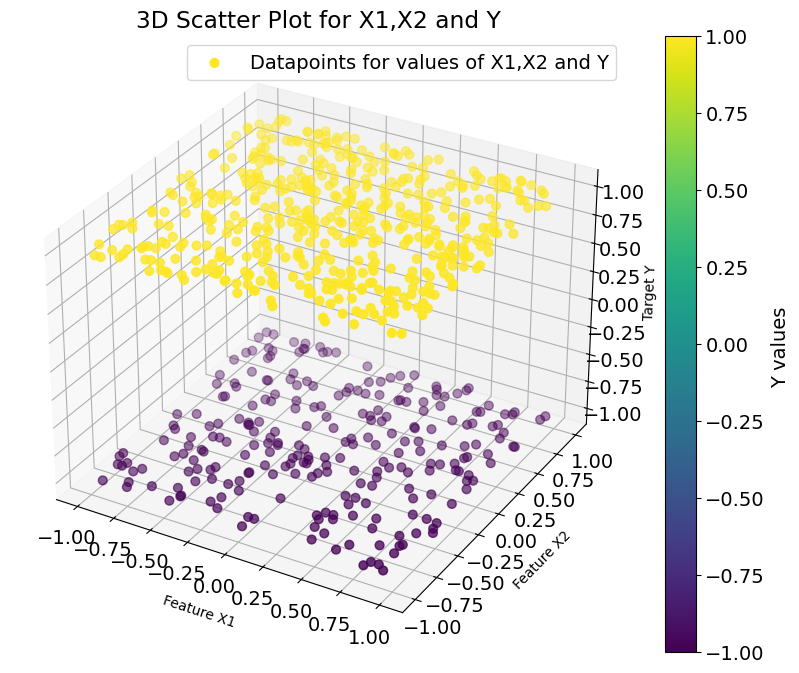

In [1110]:
#lets try it on a 3d plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #i need this for 3d plotting

fig = plt.figure(figsize = (10,8))
fig.tight_layout()


ax = fig.add_subplot(111,projection="3d" )


chart = ax.scatter(X2[:,0],X2[:,1],y2,c=y2,cmap="viridis", marker="o",s=40, label="Datapoints for values of X1,X2 and Y")
ax.set_title("3D Scatter Plot for X1,X2 and Y")
ax.set_xlabel("Feature X1",size=10,labelpad=8)
ax.set_ylabel("Feature X2",size=10,labelpad=8)
ax.set_zlabel("Target Y",labelpad=5,size=10) # labelpad just to allign how close or far i want the lable sot be for clear visibility

cbar = plt.colorbar(chart, ax=ax, shrink=1)
cbar.set_label("Y values ")
plt.legend()
plt.show()

# plt.zlabel("Y") there is no zlable due to which we have to try another approach

(i) Start with the first dataset.


(a) Using sklearn augment the two features in the dataset with polynomial features and train a Logistic Regression classifier with L2 penalty added to the cost function. Use cross-validation to select (i) the maximum order of polynomial to use and (ii) the weight C given to the penalty in the cost function. Remember you’ll also need to select the range of C values to consider and the range of maximum polynomial orders.

In [1111]:
# to pick the right metrics lets first analyse the dataset 
from collections import Counter 

print("Class counts : ", Counter()) #counts how many time each class is present in ou data

#returns the counts remove label
class_counts = np.array(list(Counter(y2).values()), dtype=float)
#print(class_counts)

#imbalance ration
imbalance = class_counts.max()/class_counts.min()
print(f" Imbalance ratio is (max/min): {imbalance:.2f}")

# note if imbalance ratio is close to 1 then it is balanced and if it is larger then imbalanced 


Class counts :  Counter()
 Imbalance ratio is (max/min): 1.95


Our data is imbalanced then lets then pick the metrics suitable for imbalanced datasets which is f1 macro

In [1112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler,PolynomialFeatures


#hardcoded range 
#deg = [1,2,3,4,5,6,7,8,9,10] lets keep this as above "degrees"

# Let us specify what will be our values of C
C_all = np.logspace(-8,8,20) #this means that from logaithmically 10^-2 to 10^3 we have to find 10 numbers 
#why logarithmic now this will give us better coverage of small to learge values

res2 = []

In [1113]:
print(degrees)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [1114]:
for d in degrees:

    poly = PolynomialFeatures(degree=d, include_bias=False) # include_bias false is just not to add any constant
    X_poly = poly.fit_transform(X2)


    #standardisation is important 
    scaler = StandardScaler()
    X_scal2 = scaler.fit_transform(X_poly)
    # why have i not used the code before because of data leakage issue here but as a part of this assignment we will ignore this

    for C in C_all:
        # i have to train model on logistic regression because it is imp to note that corss validation wont train by itself
        model2 = LogisticRegression(C=C, penalty="l2", solver = "lbfgs", max_iter=10000)

        # note that cross validation is just evaluation metric on diff folds
        scores_f1_2 = cross_val_score(model2, X_scal2, y2, cv=5, scoring='f1_macro')

        res2.append([d,C,
                        scores_f1_2.mean(),
                        scores_f1_2.std()
    
        ])
    

In [1115]:

result_df = pd.DataFrame(res2, columns=['degree','C','mean_f1','std_f1'])
#print(result_df.head())
#print(result_df.shape)
print(result_df)
                                       

     degree             C   mean_f1    std_f1
0         1  1.000000e-08  0.398051  0.000645
1         1  6.951928e-08  0.398051  0.000645
2         1  4.832930e-07  0.398051  0.000645
3         1  3.359818e-06  0.398051  0.000645
4         1  2.335721e-05  0.398051  0.000645
..      ...           ...       ...       ...
195      10  4.281332e+04  0.437604  0.013300
196      10  2.976351e+05  0.434819  0.015080
197      10  2.069138e+06  0.432748  0.018105
198      10  1.438450e+07  0.432463  0.012901
199      10  1.000000e+08  0.434095  0.016469

[200 rows x 4 columns]


In [1116]:
#mathemtiaclly analysing the f1 score lets pick the best value and then we can check this wth our plots later
# Lets analyse the df and try to pcik the row with highest mean_f1

st_mean = result_df.loc[result_df['mean_f1'].idxmax()]
st_degree = int(st_mean['degree'])
st_c = float(st_mean["C"])

print("Best degree by F1", st_degree)
print("Best c value :", st_c)
print(st_mean)

Best degree by F1 9
Best c value : 885.8667904100796
degree       9.000000
C          885.866790
mean_f1      0.438601
std_f1       0.024334
Name: 173, dtype: float64


/var/folders/9c/3z7htchs3r35xyhy05wqv5wc0000gn/T/ipykernel_1305/3337486212.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/9c/3z7htchs3r35xyhy05wqv5wc0000gn/T/ipykernel_1305/3337486212.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


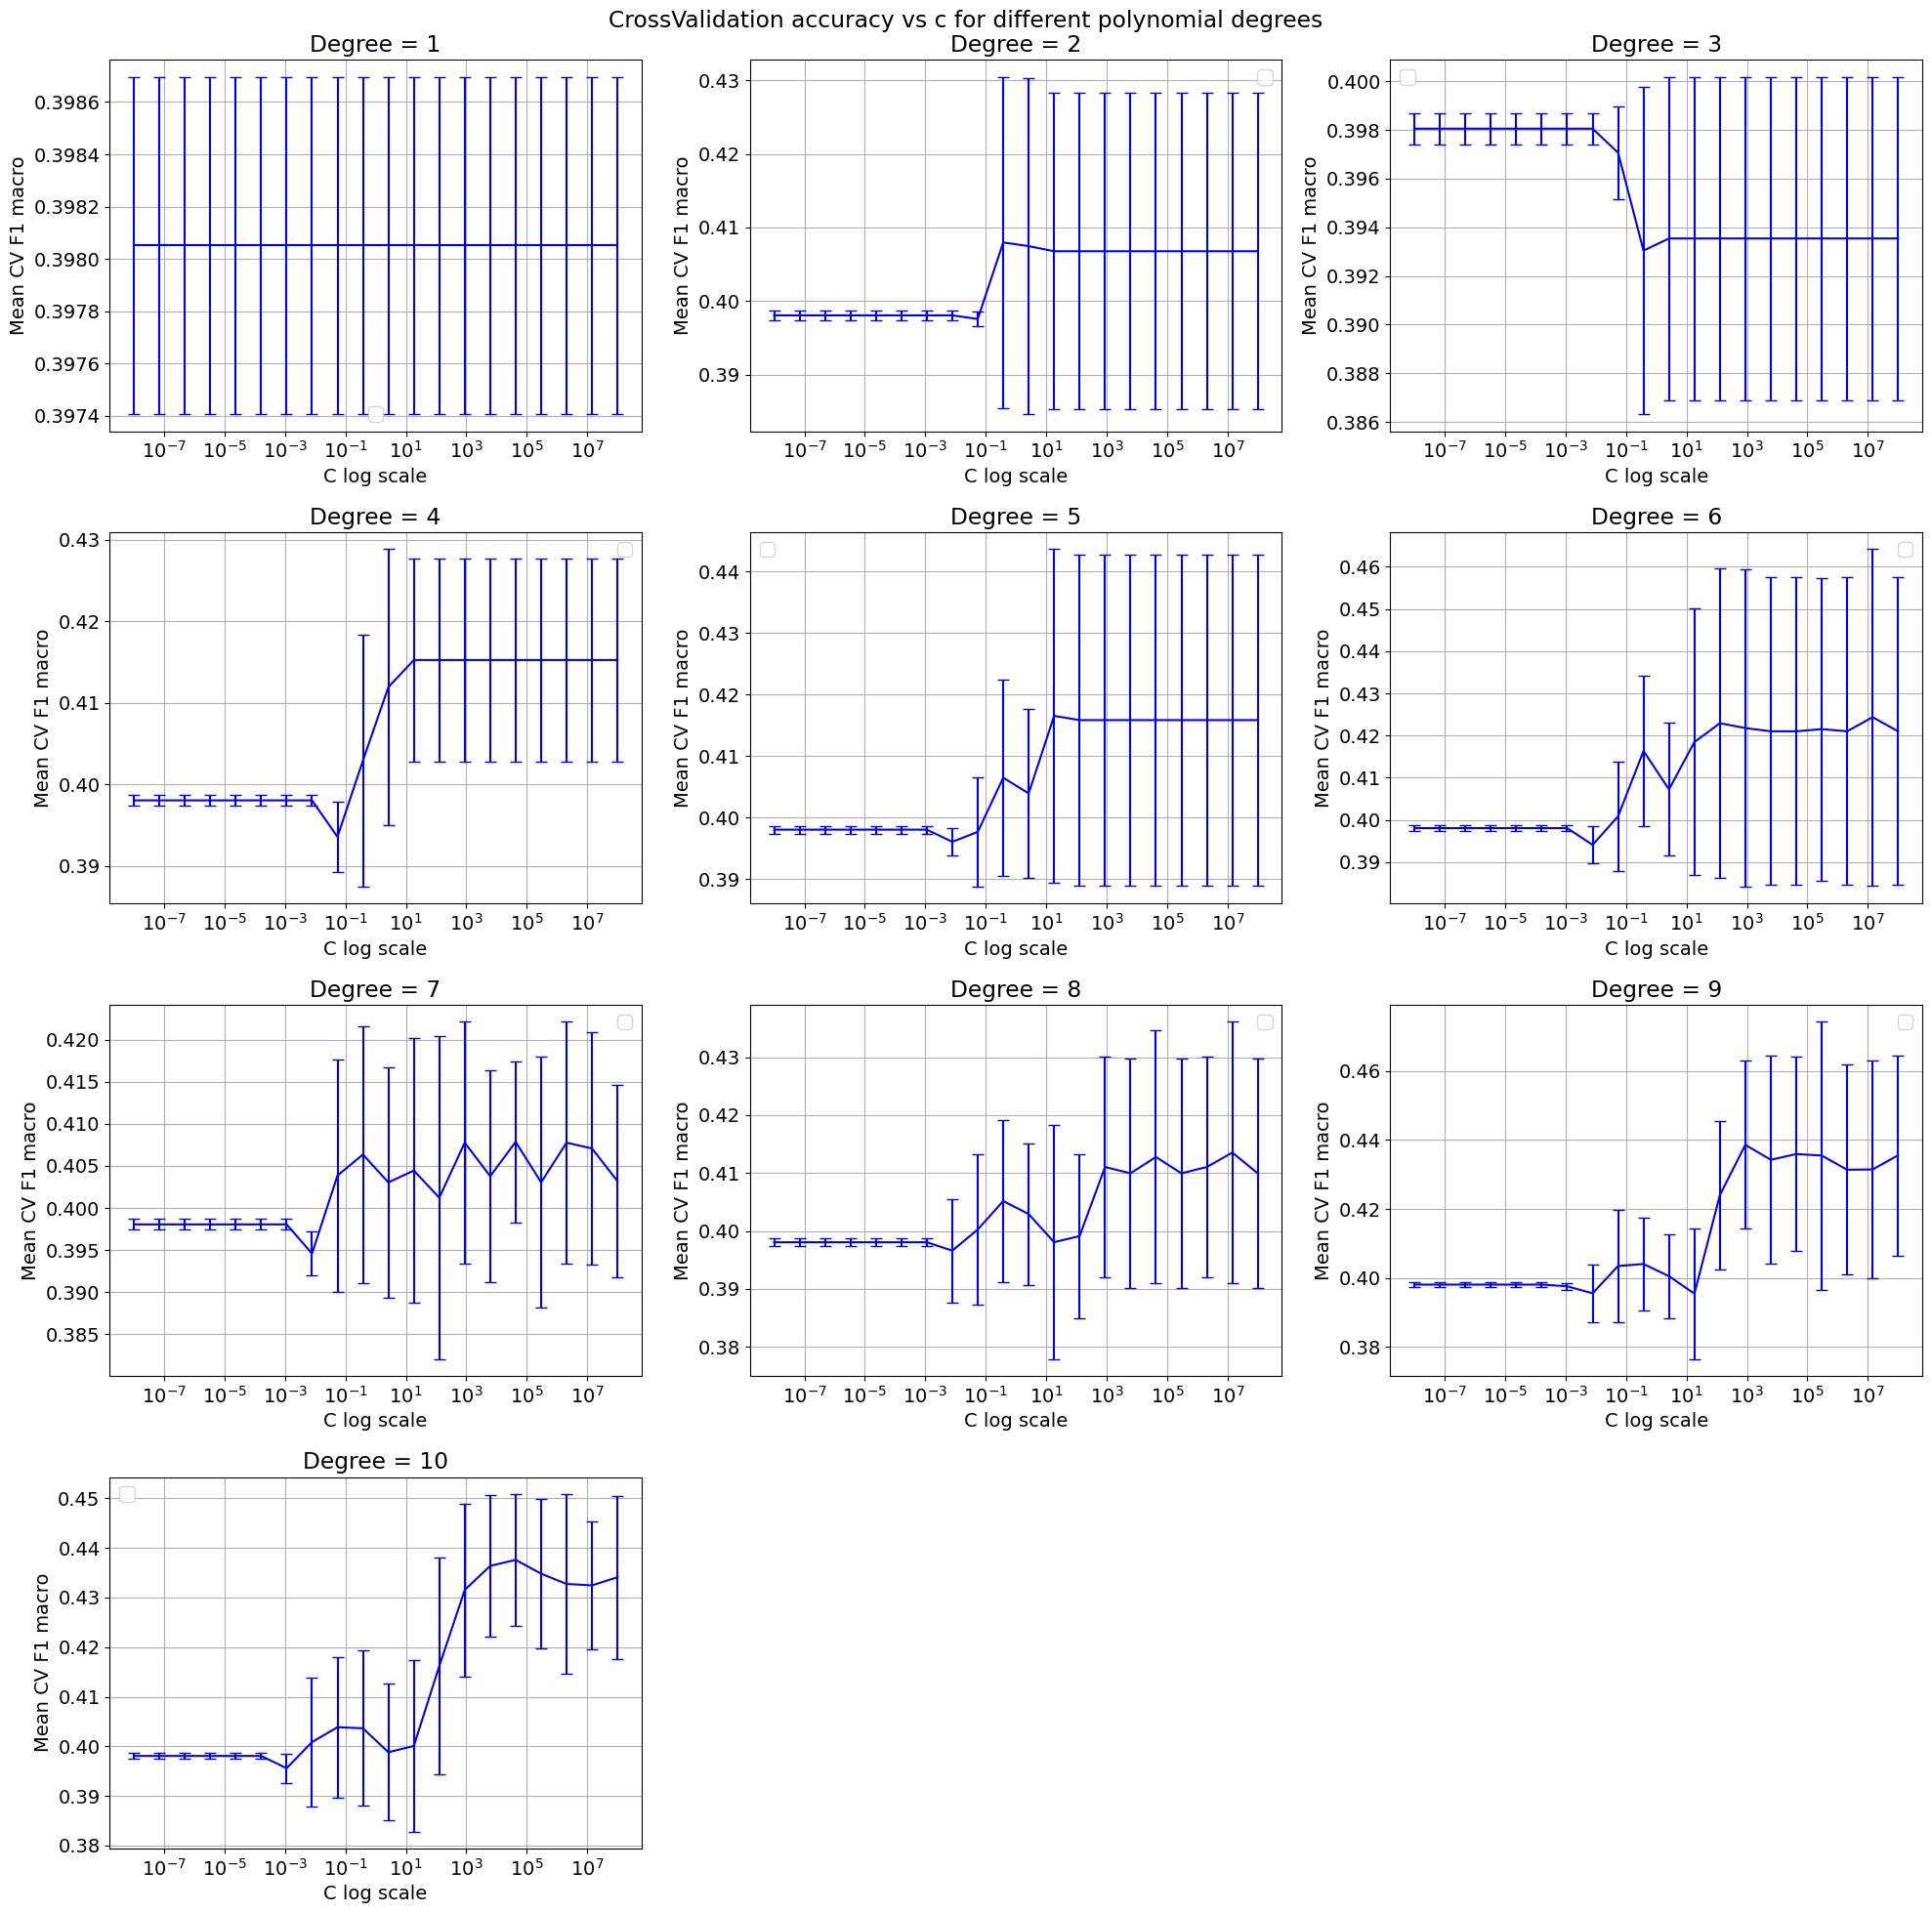

In [1117]:
# lets have a grid type structure to be able to compare everything on a single plot side by side

cols = 3
rows = 4 #why because we have 10 plots divided by 3 cols so we need 4 rows 

plt.figure(figsize=(20,20))

for i,d in enumerate(degrees, 1):  #iterate with i=1, d=1 and i=2, d=2 and so on
    sub = result_df[result_df['degree']==d].sort_values('C') #only choose degree as d this is for condition within loop 
    plt.subplot(rows,cols,i)

    plt.errorbar(
        sub['C'],
        sub['mean_f1'], #mean is on Y axis 
        yerr = sub['std_f1'],   # here we have std deviation to show how values have deviated from the catual value in the graph
        capsize=4,
        color='blue'
    )
    plt.xscale("log")
    plt.xlabel("C log scale")
    plt.ylabel("Mean CV F1 macro")
    plt.title(f"Degree = {d}")
    plt.legend()
    plt.grid(True)

plt.suptitle("CrossValidation accuracy vs c for different polynomial degrees")
plt.tight_layout()
plt.show()

/var/folders/9c/3z7htchs3r35xyhy05wqv5wc0000gn/T/ipykernel_1305/2878269487.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Degree = 9')

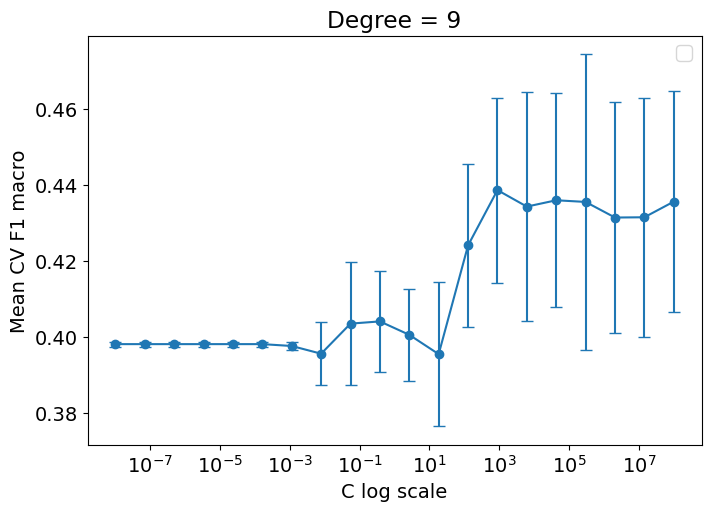

In [1118]:

sub = result_df[result_df['degree']==9].sort_values('C') #only choose degree as d this is for condition within loop 

plt.figure(figsize=(7,5))

plt.errorbar(
    sub['C'],
    sub['mean_f1'],
    yerr=sub['std_f1'],
    capsize = 4,
    marker='o',
)

plt.xscale("log")
plt.xlabel("C log scale")
plt.ylabel("Mean CV F1 macro")
plt.legend()
plt.title(f"Degree = 9")


/var/folders/9c/3z7htchs3r35xyhy05wqv5wc0000gn/T/ipykernel_1305/2026684921.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Degree = 5')

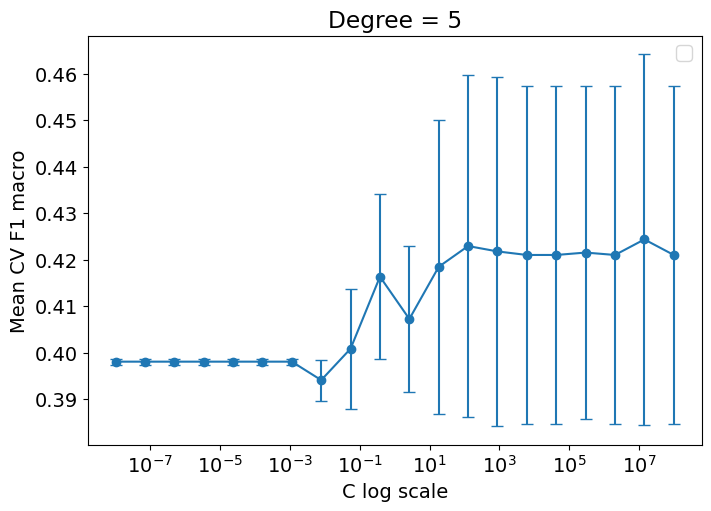

In [1119]:

sub = result_df[result_df['degree']==6].sort_values('C') #only choose degree as d this is for condition within loop 

plt.figure(figsize=(7,5))

plt.errorbar(
    sub['C'],
    sub['mean_f1'],
    yerr=sub['std_f1'],
    capsize = 4,
    marker='o',
)

plt.xscale("log")
plt.xlabel("C log scale")
plt.ylabel("Mean CV F1 macro")
plt.legend()
plt.title(f"Degree = 5")


In [1120]:
deg6_rows = result_df[result_df['degree'] == 6]
print(deg6_rows.sort_values('mean_f1', ascending=False).head())


     degree             C   mean_f1    std_f1
118       6  1.438450e+07  0.424351  0.039836
112       6  1.274275e+02  0.422924  0.036726
113       6  8.858668e+02  0.421768  0.037609
116       6  2.976351e+05  0.421521  0.035901
119       6  1.000000e+08  0.421005  0.036460


In [1121]:
deg9_rows = result_df[result_df['degree'] == 9]
print(deg9_rows.sort_values('mean_f1', ascending=False).head())


     degree             C   mean_f1    std_f1
173       9  8.858668e+02  0.438601  0.024334
175       9  4.281332e+04  0.435928  0.028233
179       9  1.000000e+08  0.435568  0.029021
176       9  2.976351e+05  0.435492  0.038877
174       9  6.158482e+03  0.434262  0.030234


Degree 9 is best

In [1122]:
# FInal model traning with chose hyperparameters above 
chosen_c=1000
chosen_d=9

poly = PolynomialFeatures(degree=chosen_d, include_bias=False) # include_bias false is just not to add any constant
X_poly = poly.fit_transform(X2)

#standardisation is important 
scaler = StandardScaler()
X_scal2 = scaler.fit_transform(X_poly)

"""best_degree = int(high_mean['degree'])
best_c = float(high_mean["C"])"""

model_logistic2 = LogisticRegression(C=chosen_c, penalty='l2',solver='lbfgs', max_iter=10000)
model_logistic2.fit(X_scal2, y2)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1000
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


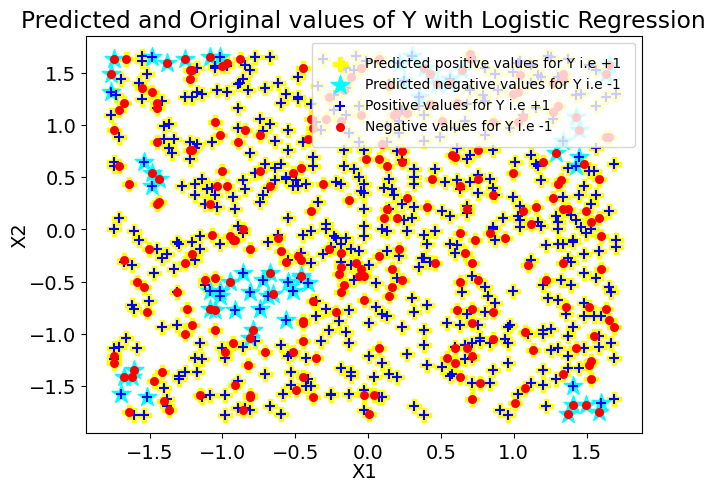

In [1123]:
ypred2 = model_logistic2.predict(X_scal2)
log_scores2 = model_logistic2.predict_proba(X_scal2)[:,1]


plt.scatter(X_scal2[ypred2==1,0],
            X_scal2[ypred2==1,1], 
            marker="P", 
            color ="yellow",
            label="Predicted positive values for Y i.e +1",
            s=100)

plt.scatter(X_scal2[ypred2==-1,0],
            X_scal2[ypred2==-1,1], 
            marker="*",
            color="cyan", 
            label="Predicted negative values for Y i.e -1",
            s=200)

plt.scatter(X_scal2[y2==1,0],
            X_scal2[y2==1,1], 
            marker="+", 
            color ="blue", 
            label="Positive values for Y i.e +1",
            s=50)

plt.scatter(X_scal2[y2==-1,0],
            X_scal2[y2==-1,1], 
            marker="o",
            color="red", 
            label="Negative values for Y i.e -1",
            s=30)

plt.title("Predicted and Original values of Y with Logistic Regression")
plt.xlabel("X1",labelpad=-0.12)
plt.ylabel("X2",labelpad=-0.12)
plt.legend(handlelength=2, borderpad=1,fontsize=10, loc="upper right")


# (b)

In [1124]:
from sklearn.neighbors import KNeighborsClassifier

# now everything from previous section ive pasted here and we start the same orcess but for Knn
# now this time the complaexity is less because we just have to parse thorugh diff values of degree 
#there is no C 

k2=range(1,20)

result_knn2=[]
for k in k2:
        

        model_knn2 = KNeighborsClassifier(n_neighbors=k, weights='uniform')

        f1_scores = cross_val_score(model_knn2, X2, y2, cv=5, scoring='f1_macro')


        result_knn2.append([k,
                        f1_scores.mean(),
                        f1_scores.std()
    
        ])

res_knn_df2 = pd.DataFrame(result_knn2, columns=['k','mean_f1','std_f1'])
print(res_knn_df2)

     k   mean_f1    std_f1
0    1  0.488060  0.045399
1    2  0.449354  0.016840
2    3  0.470869  0.025191
3    4  0.492493  0.031037
4    5  0.456662  0.022963
5    6  0.475948  0.044160
6    7  0.481223  0.030467
7    8  0.487000  0.029454
8    9  0.455972  0.036563
9   10  0.475238  0.025582
10  11  0.450497  0.035818
11  12  0.476347  0.030132
12  13  0.442145  0.014803
13  14  0.457872  0.023391
14  15  0.434512  0.030543
15  16  0.449895  0.039881
16  17  0.437678  0.028702
17  18  0.439894  0.036734
18  19  0.413134  0.026490


In [1125]:
# now as done previously im going to find the best C mathematically 
best_knn = res_knn_df2.loc[res_knn_df2['mean_f1'].idxmax()]
best_k2 = int(best_knn['k'])
print("Best value of k by f1 is : ", best_k2)
print(best_knn)

Best value of k by f1 is :  4
k          4.000000
mean_f1    0.492493
std_f1     0.031037
Name: 3, dtype: float64


/var/folders/9c/3z7htchs3r35xyhy05wqv5wc0000gn/T/ipykernel_1305/2424566143.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


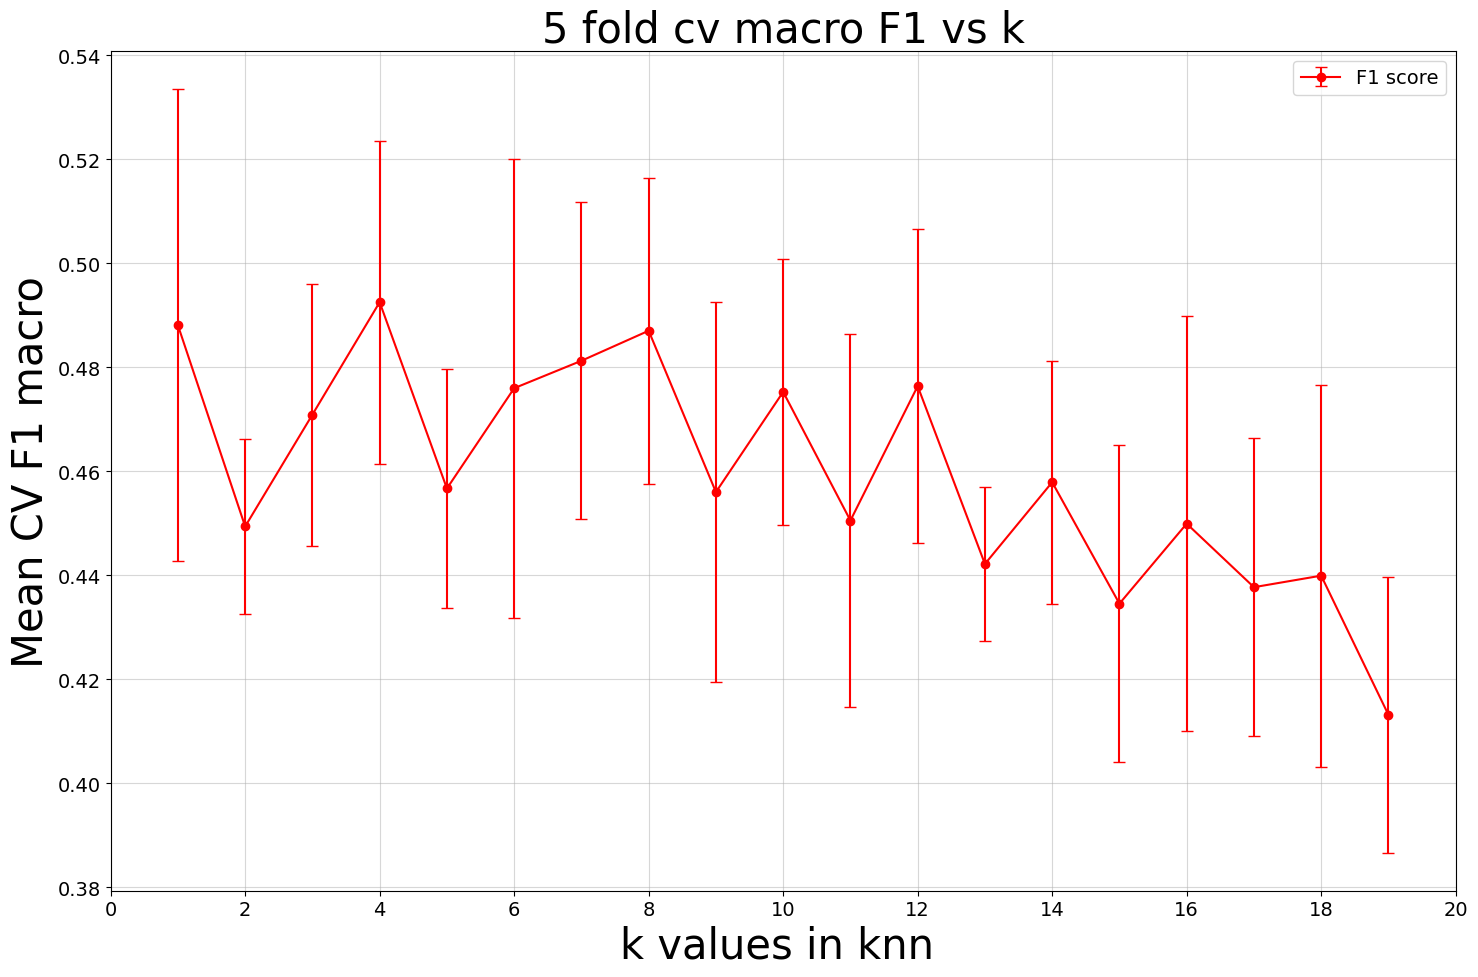

In [1126]:
# here there is no need for multiple plots because tchnically we will have only 1 plot 
# x axis will be k values
# y will be mean of f1 scores and the std deiation with the error bar 

plt.figure(figsize=(15,10))
plt.errorbar(
    res_knn_df2['k'],
    res_knn_df2['mean_f1'],
    yerr = res_knn_df2['std_f1'],
    capsize=4,
    marker='o',
    color='red',
    label='F1 score',
)
plt.xlabel("k values in knn ",size=30)
plt.ylabel("Mean CV F1 macro",size=30)
plt.xticks(range(0,21,2))
plt.title("5 fold cv macro F1 vs k",size=30)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.legend()

plt.show()

1. small k = more flexible and might react to any noise in the data
2. big k = smoother averages more neighbour but less flwible 
3. short bar =. stable model and similar performnace in every fold
4. long bar = unstable model

k=8 

In [1127]:
# FInal model traning with chose hyperparameters above 
#standardisation is important 

"""best_degree = int(high_mean['degree'])
best_c = float(high_mean["C"])"""

model_knn2 = KNeighborsClassifier(n_neighbors=8, weights='uniform')
model_knn2.fit(X2, y2)

ypred_knn2 = model_knn2.predict(X2)
knn_scores2 = model_knn2.predict_proba(X2)[:,1]




In [1128]:
print(X2.shape)
print(ypred_knn2.shape)

print(y2.shape)



(741, 2)
(741,)
(741,)


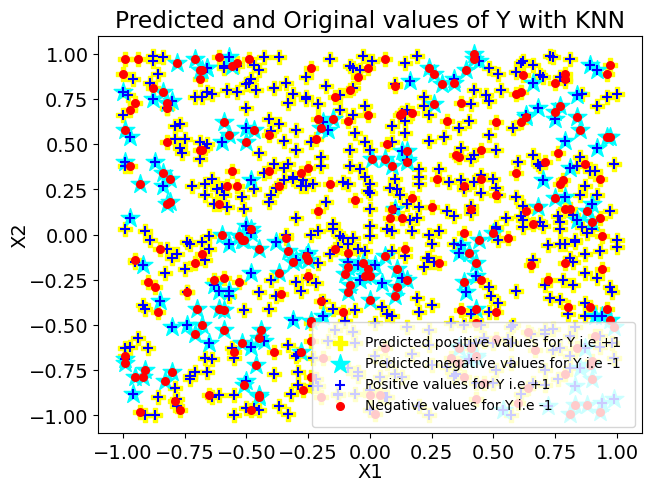

In [1129]:
plt.scatter(X2[ypred_knn2==1,0],
            X2[ypred_knn2==1,1], 
            marker="P", 
            color ="yellow",
            label="Predicted positive values for Y i.e +1",
            s=100)

plt.scatter(X2[ypred_knn2==-1,0],
            X2[ypred_knn2==-1,1], 
            marker="*",
            color="cyan", 
            label="Predicted negative values for Y i.e -1",
            s=200)

plt.scatter(X2[y2==1,0],
            X2[y2==1,1], 
            marker="+", 
            color ="blue", 
            label="Positive values for Y i.e +1",
            s=50)

plt.scatter(X2[y2==-1,0],
            X2[y2==-1,1], 
            marker="o",
            color="red", 
            label="Negative values for Y i.e -1",
            s=30)

plt.title("Predicted and Original values of Y with KNN")
plt.xlabel("X1",labelpad=-0.12)
plt.ylabel("X2",labelpad=-0.12)
plt.legend(handlelength=2, borderpad=1,fontsize=10, loc="lower right")


In [1130]:
# we have evlauted on full training data because we have not done splitting in previous steps
from sklearn.dummy import DummyClassifier

dummy_majority_pred2 = DummyClassifier(strategy="most_frequent")
dummy_majority_pred2.fit(X2,y2)
y_pred_majority2 = dummy_majority_pred2.predict(X2)

dummy_random_pick2 = DummyClassifier(strategy="uniform",random_state=0)
dummy_random_pick2.fit(X2,y2)
y_pred_random2 = dummy_random_pick2.predict(X2)

In [1131]:
#Confusion matrix of all data 
label=[-1,1]

from sklearn.metrics import confusion_matrix, classification_report

print("Confusion matrix for logistic regression")
print(confusion_matrix(y2, ypred2, labels=label))


print("Confusion matrix for logistic regression")
print(classification_report(y2, ypred2, labels=label))



Confusion matrix for logistic regression
[[ 32 219]
 [ 31 459]]
Confusion matrix for logistic regression
              precision    recall  f1-score   support

          -1       0.51      0.13      0.20       251
           1       0.68      0.94      0.79       490

    accuracy                           0.66       741
   macro avg       0.59      0.53      0.49       741
weighted avg       0.62      0.66      0.59       741



In [1132]:
print("Confusion matrix for KNN")
print(confusion_matrix(y2, ypred_knn2, labels=label))

print("Classification report for KNN")
print(classification_report(y2, ypred_knn2, labels=label))


Confusion matrix for KNN
[[105 146]
 [ 80 410]]
Classification report for KNN
              precision    recall  f1-score   support

          -1       0.57      0.42      0.48       251
           1       0.74      0.84      0.78       490

    accuracy                           0.70       741
   macro avg       0.65      0.63      0.63       741
weighted avg       0.68      0.70      0.68       741



In [1133]:
print("Confusion matrix for Baseline predictor majority  ")
print(confusion_matrix(y2, y_pred_majority2, labels=label))

print("Classification report for Baseline predictor majority ")
print(classification_report(y2, y_pred_majority2, labels=label))

Confusion matrix for Baseline predictor majority  
[[  0 251]
 [  0 490]]
Classification report for Baseline predictor majority 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       251
           1       0.66      1.00      0.80       490

    accuracy                           0.66       741
   macro avg       0.33      0.50      0.40       741
weighted avg       0.44      0.66      0.53       741



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

In [1134]:
print("Confusion matrix for Baseline predictor random  ")
print(confusion_matrix(y2, y_pred_random2, labels=label))

print("Classification report for Baseline predictor random ")
print(classification_report(y2, y_pred_random2, labels=label))

Confusion matrix for Baseline predictor random  
[[103 148]
 [252 238]]
Classification report for Baseline predictor random 
              precision    recall  f1-score   support

          -1       0.29      0.41      0.34       251
           1       0.62      0.49      0.54       490

    accuracy                           0.46       741
   macro avg       0.45      0.45      0.44       741
weighted avg       0.51      0.46      0.47       741



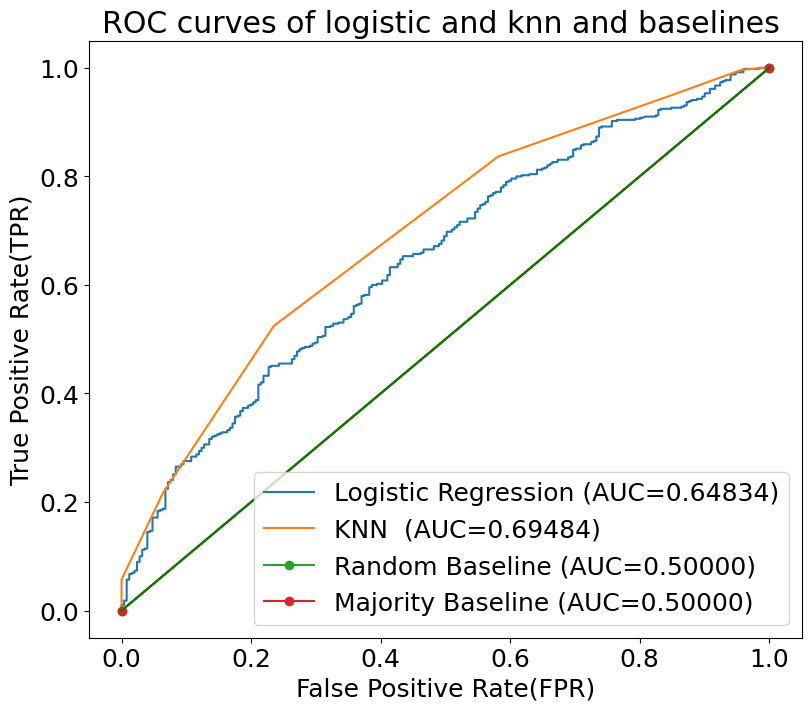

In [1135]:
# we need 
log_scores2 = model_logistic2.predict_proba(X_scal2)[:,1]


from sklearn.metrics import roc_auc_score, roc_curve

#log_scores = model_logistic.predict_proba(X_scal)[:,1]
#knn_scores = model_knn.predict_proba(X1_scal)[:,1]

random_scores2 = dummy_random_pick2.predict_proba(X2)[:,1]
majority_scores2 = dummy_majority_pred2.predict_proba(X2)[:,1]

fpr_log, tpr_log, _=roc_curve(y2,log_scores2, pos_label=1)
fpr_knn, tpr_knn, _=roc_curve(y2,knn_scores2, pos_label=1)
fpr_rd, tpr_rd, _=roc_curve(y2,random_scores2, pos_label=1)
fpr_maj, tpr_maj, _=roc_curve(y2,majority_scores2, pos_label=1)


auc_log2=roc_auc_score(y2,log_scores2)
auc_knn2=roc_auc_score(y2,knn_scores2)
auc_rd2=roc_auc_score(y2,random_scores2)
auc_maj2=roc_auc_score(y2,majority_scores2)


plt.rc('font', size=18)
plt.rcParams['figure.constrained_layout.use']=True
plt.figure(figsize=(8,7))

plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC={auc_log2:.5f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN  (AUC={auc_knn2:.5f})")

plt.plot(fpr_rd, tpr_rd, label=f"Random Baseline (AUC={auc_rd:.5f})",marker="o")
plt.plot(fpr_maj, tpr_maj, label=f"Majority Baseline (AUC={auc_maj:.5f})",marker="o")

plt.plot([0,1],[0,1], color="green")

plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC curves of logistic and knn and baselines ")
plt.legend()
plt.show()